<a href="https://colab.research.google.com/github/ferdouszislam/Bangla-Handwritting-Aesthetics-Prediction-ML/blob/main/codes/experimentation_5_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import torch
import numpy as np
import math
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# mount gdrive with this code
from google.colab import drive
drive.mount('/content/drive')

# extract the zip file containing our dataset
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/BanglaLekha-Isolated_aesthetics_dataset/5_class.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# set all random seeds
SEED = 42

def set_global_seed():
  #torch.backends.cudnn.deterministic = True
  #torch.backends.cudnn.benchmark = False
  #random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  #np.random.seed(SEED)

set_global_seed()

In [5]:
# custom dataset class
class BanglaLekhaAesScoreLabledDataset(Dataset):
  def __init__(self, labels_csv_file, img_dir, transform=None):
    self.labels_df = pd.read_csv(labels_csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels_df)

  def __getitem__(self, index):
    img_path = os.path.join(self.img_dir, self.labels_df.iloc[index, 0])
    image = io.imread(img_path)
    if self.transform:
      image = self.transform(image)
    
    y_label = torch.tensor(self.labels_df.iloc[index, 7])
    y_label = torch.add(y_label, -1)
    #print(y_label)
    
    return (image, y_label)

In [6]:
# load data

# resize to same shape and convert to tensor
custom_transform = transforms.Compose([transforms.ToPILImage(), 
                                       transforms.Resize((50, 50)), 
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.5,), (0.5,))
                                       ])

train_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_train.csv', 
                                        img_dir='/tmp/5_class/train_images', transform=custom_transform)
val_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_val.csv', 
                                        img_dir='/tmp/5_class/validation_images', transform=custom_transform)
test_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_test.csv', 
                                        img_dir='/tmp/5_class/test_images', transform=custom_transform)

# data loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# visualize data
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (25,4))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=25).permute(1,2,0))
        #print(images.shape)
        break

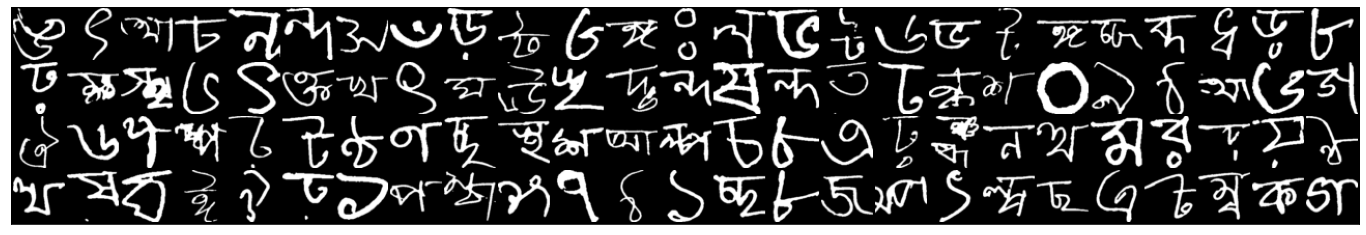

In [8]:
show_batch(val_loader)

# Experimentation with various NNs starts from here

In [9]:
# hyperparameters
INPUT_SIZE = 50*50
ANN_FC1_SIZE = 256
ANN_FC2_SIZE = 128
ANN_FC3_SIZE = 64
CONV1_FILTERS = 16
CONV2_FILTERS = 32
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

In [10]:
# custom ANN class with 3 hidden layers, relu activation and dropout on each hidden layer
class ANN(nn.Module):
  def __init__(self, input_size=INPUT_SIZE, fc1_size=256, fc2_size=128, fc3_size=64):
    super(ANN, self).__init__()
    self.input_size = input_size
    self.fc1 = nn.Linear(input_size, fc1_size)
    self.dropout_fc1 = nn.Dropout(0.75)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.dropout_fc2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(fc2_size, fc3_size)
    self.dropout_fc3 = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc3_size, 5)

  def forward(self, input):
    # flatten input
    input = input.reshape(-1, self.input_size) 
    # input layer to hidden layer 1
    output = self.dropout_fc1(self.fc1(input))
    output = self.relu(output)
    # hidden layer 1 to hidden layer 2
    output = self.dropout_fc2(self.fc2(output))
    output = self.relu(output)
    # hidden layer 2 to hidden layer 3
    output = self.dropout_fc3(self.fc3(output))
    output = self.relu(output)
    # hidden layer 3 to output
    output = self.output_layer(output)
    output = self.relu(output)
    return output

In [11]:
# custom cnn class 
class CNN(nn.Module):
  def __init__(self, conv1_filters=16, conv2_filters=32, fc1_size=256, fc2_size=64):
    super(CNN, self).__init__()
    
    self.conv1_filters = conv1_filters
    self.conv2_filters = conv2_filters

    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(1, conv1_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv1_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_layer2 =  nn.Sequential(
        nn.Conv2d(conv1_filters, conv2_filters, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(conv2_filters),
        nn.Dropout(0.25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # conv layer explanation with: conv1_filters=16, conv2_filters=32
    # 1x50x50 --conv1--> 16x50x50 --maxpool--> 16x25x25
    # 16x25x25 --conv2--> 32x25x25 --maxpool--> 32x12x12

    self.fc1 = nn.Linear(conv2_filters*12*12, fc1_size) 
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.relu = nn.ReLU()
    self.fc_dropout = nn.Dropout(0.5)
    self.output_layer = nn.Linear(fc2_size, 5)
      
  def forward(self, input):
    #print('inside forward', input.shape)

    # input to conv_layer1
    output = self.conv_layer1(input)
    #print('after conv1', output.shape)

    # conv_layer1 to conv_layer2
    output = self.conv_layer2(output)
    #print('after conv2', output.shape)

    # conv_layer2 to fc1
    output = output.reshape(-1, self.conv2_filters*12*12) # flatten
    output = self.fc1(output)
    output = self.relu(self.fc_dropout(output))

    # fc1 to fc2
    output = self.fc2(output)
    output = self.relu(self.fc_dropout(output))

    # fc2 to prediction
    output = self.output_layer(output)
    output = self.relu(output)

    return output

  def _get_result_dims(input_dims, conv_dims, p=0, s=1):
    # get resulting matrix(2d) dimensions after convolution
    
    resulting_dims = []
    resulting_dims.append(int((input_dims[0] - conv_dims[0] + 2*p)/s)+1)
    resulting_dims.append(int((input_dims[1] - conv_dims[1] + 2*p)/s)+1)
    
    return resulting_dims

In [12]:
# class to calculate accuracy of model, using batches of data
class Accuracy_Calc():
  def __init__(self):
    self.n_correct_samples = 0
    self.n_total_samples = 0

  def add_batch(self, pred_labels, gt_labels):
    pred_labels = torch.round(pred_labels)
    gt_labels = torch.round(gt_labels)

    self.n_total_samples+=gt_labels.size(0)
    self.n_correct_samples+=pred_labels.eq(gt_labels).sum().item()

  def get_accuracy(self):
    return 100*self.n_correct_samples/self.n_total_samples

In [13]:
# class to calculate f1 score supporting average, macro, micro f1 score for multi-classes

from typing import Tuple

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    
    courtesy- <https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch> 
    
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    def _calc_f1_micro(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    def _calc_f1_count_for_label(self, predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        
        # print(f'for class {label_id}: precision={precision:.2f}, recall={recall:.2f}, f1={f1:.2f}, TP={true_positive}, freq={true_count}')
        
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self._calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self._calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

In [14]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    min_train_val_acc_diff = np.inf
    
    curr_train_acc = 0.0
    curr_train_weighted_f1 = 0.0
    curr_val_acc = 0.0
    curr_val_weighted_f1 = 0.0
    
    selected_epoch = 0
    selected_train_acc = 0.0
    selected_train_weighted_f1 = 0.0
    selected_val_acc = 0.0
    selected_val_weighted_f1 = 0.0

    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    train_weighted_f1s = []
    val_weighted_f1s = []

    f1_score_calc = F1Score()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_weighted_f1 = 0.0

            data_loader = train_loader if phase == 'train' else val_loader

            # Iterate over data.
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # print(preds.shape, labels.shape)
                    # print(preds, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() #* inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_weighted_f1 += f1_score_calc(preds, labels)

            epoch_loss = running_loss / len(data_loader)
            epoch_acc = running_corrects.double() / len(data_loader)
            epoch_weighted_f1 = running_weighted_f1 / len(data_loader)

            if phase == 'train':
              curr_train_acc = epoch_acc
              curr_train_weighted_f1 = epoch_weighted_f1
              train_accs.append(epoch_acc)
              train_losses.append(epoch_loss)
              train_weighted_f1s.append(epoch_weighted_f1)
            else:
              curr_val_acc = epoch_acc
              curr_val_weighted_f1 = epoch_weighted_f1
              val_accs.append(epoch_acc)
              val_losses.append(epoch_loss)
              val_weighted_f1s.append(epoch_weighted_f1)

            print('{} Loss: {:.4f} Acc: {:.4f}, Weighted F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_weighted_f1))

            if phase == 'val':
              # deep copy the model
              curr_train_val_acc_diff = abs(curr_val_acc-curr_train_acc)
              if curr_train_val_acc_diff < min_train_val_acc_diff or (curr_train_val_acc_diff == min_train_val_acc_diff and curr_val_acc > selected_val_acc):
                min_train_val_acc_diff = abs(curr_val_acc-curr_train_acc)
                selected_epoch = epoch

                selected_train_acc = curr_train_acc
                selected_train_weighted_f1 = curr_train_weighted_f1
                selected_val_acc = curr_val_acc
                selected_val_weighted_f1 = curr_val_weighted_f1

                best_model_wts = copy.deepcopy(model.state_dict())
                
                print('Minimum train-val accuracy difference reduced \t Saving Model!')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Train Accuracy: {:.4f}, Weighted F1-score: {:.4f}'.format(selected_train_acc, selected_train_weighted_f1))
    print('Validation Accuracy: {:.4f}, Weighted F1-score: {:.4f}'.format(selected_val_acc, selected_val_weighted_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, selected_epoch, train_accs, train_losses, train_weighted_f1s, val_accs, val_losses, val_weighted_f1s

# evaluation 
def eval(model, test_loader):
  model.eval()
  
  f1_score_calc = F1Score()

  with torch.no_grad():
    running_loss = 0.0
    running_corrects = 0
    running_weighted_f1 = 0.0

    # Iterate over data.
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # predict
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() # * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_weighted_f1 += f1_score_calc(preds, labels)

    test_loss = running_loss / len(test_loader)
    test_acc = running_corrects.double() / len(test_loader)
    test_weighted_f1 = running_weighted_f1 / len(test_loader)

    print(f'Test Accuracy: {test_acc:0.3f}, Test Loss: {test_loss:0.3f}, Test Weighted F1: {test_weighted_f1:0.3f}')

# plot lists of train, validation scores- accuracy, loss etc
def plot_scores(score_type, train_scores, val_scores, num_epochs=NUM_EPOCHS, selected_epoch=None):
  plt.figure(figsize =(15,9))
  plt.title(f"train vs validation {score_type}", fontdict = {'fontsize' : 18})
  epochs = [epoch for epoch in range(num_epochs)]
  plt.plot(epochs, train_scores, 'ro-',  epochs, val_scores ,'bv-')

  if selected_epoch:
    plt.axvline(x=selected_epoch, color='k', linestyle='--')
    plt.legend([f'train {score_type}',f'validation {score_type}', 'selected epoch'], fontsize=16)
  
  plt.xlabel('epochs', fontsize=18)
  plt.ylabel(score_type, fontsize=18)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()

# **Custom ANN**

In [15]:
# init model with ANN
set_global_seed()
model = ANN(input_size=INPUT_SIZE, fc1_size=ANN_FC1_SIZE, fc2_size=ANN_FC2_SIZE, fc3_size=ANN_FC3_SIZE)
model = model.to(device)

# init loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS)

Epoch 0/1
---------------
train Loss: 1.4315 Acc: 31.9025, Weighted F1: 0.2193
val Loss: 1.4126 Acc: 35.6820, Weighted F1: 0.2332
Minimum train-val accuracy difference reduced 	 Saving Model!

Epoch 1/1
---------------
train Loss: 1.3991 Acc: 33.6129, Weighted F1: 0.2286
val Loss: 1.4018 Acc: 33.1379, Weighted F1: 0.1919
Minimum train-val accuracy difference reduced 	 Saving Model!

Training complete in 5m 21s
Train Acc: 33.612933, Weighted F1-score: 0.228624
Validation Acc: 33.137931 Weighted F1-score: 0.191875


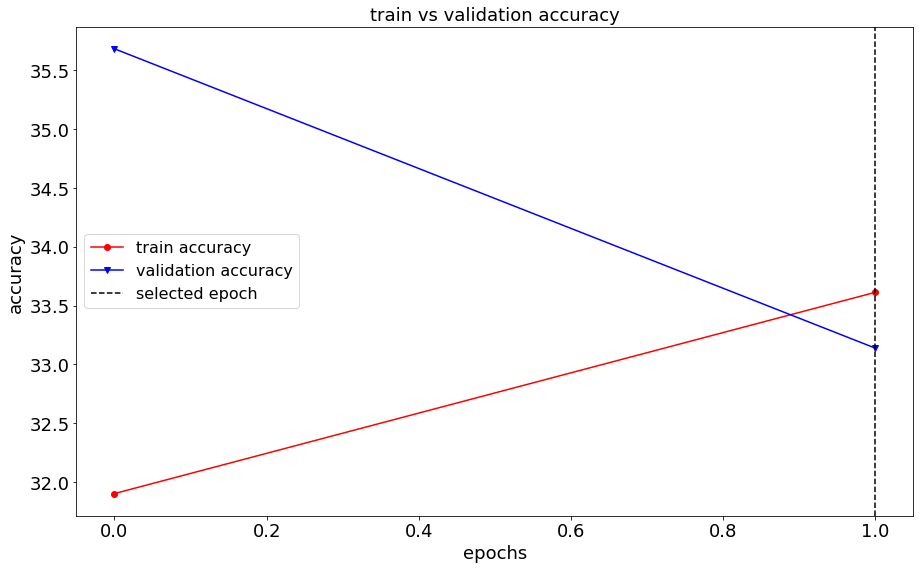

In [16]:
plot_scores("accuracy", train_accs, val_accs, NUM_EPOCHS, selected_epoch)

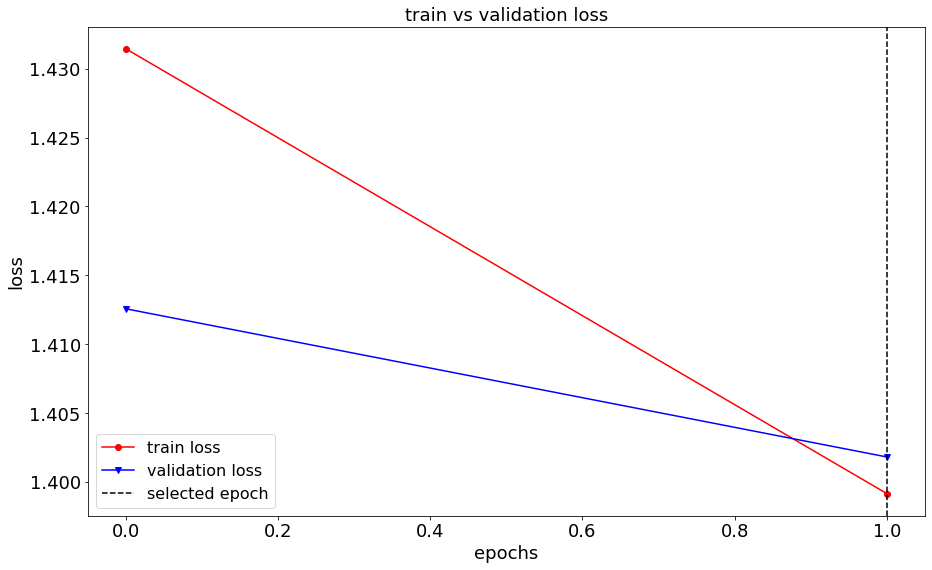

In [17]:
plot_scores("loss", train_losses, val_losses, NUM_EPOCHS, selected_epoch)

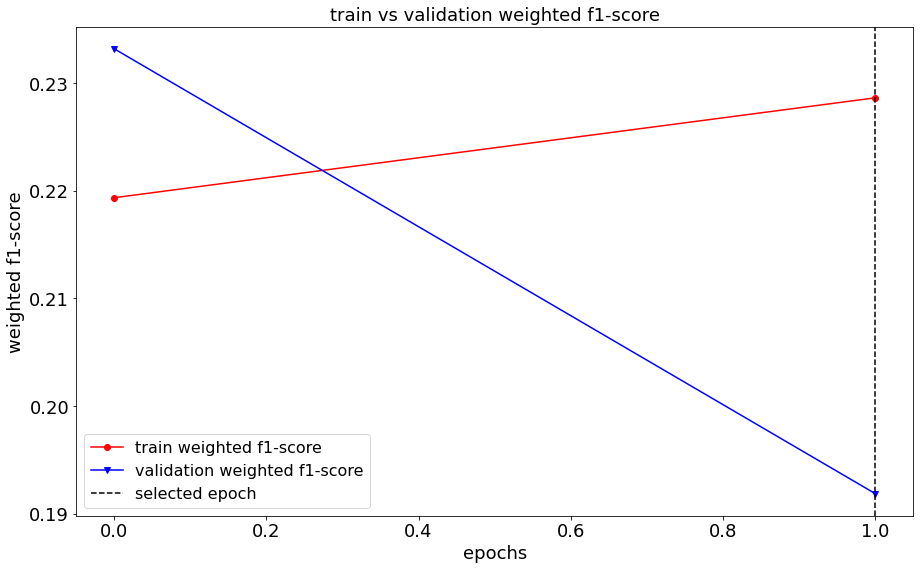

In [18]:
plot_scores('weighted f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [19]:
eval(model=model, test_loader=test_loader)

Test Accuracy:  32.329, Test Loss:  1.409, Test Weighted F1:  0.167


# **Custom CNN**

In [20]:
# init model with CNN
set_global_seed()
model = CNN()
model = model.to(device)

# init loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS)

Epoch 0/1
---------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 1.3944 Acc: 35.1368, Weighted F1: 0.2278
val Loss: 1.3735 Acc: 35.9923, Weighted F1: 0.2196
Minimum train-val accuracy difference reduced 	 Saving Model!

Epoch 1/1
---------------
train Loss: 1.3257 Acc: 38.6823, Weighted F1: 0.2554
val Loss: 1.3190 Acc: 40.9502, Weighted F1: 0.2676

Training complete in 5m 59s
Train Acc: 35.136832, Weighted F1-score: 0.227804
Validation Acc: 35.992337 Weighted F1-score: 0.219615


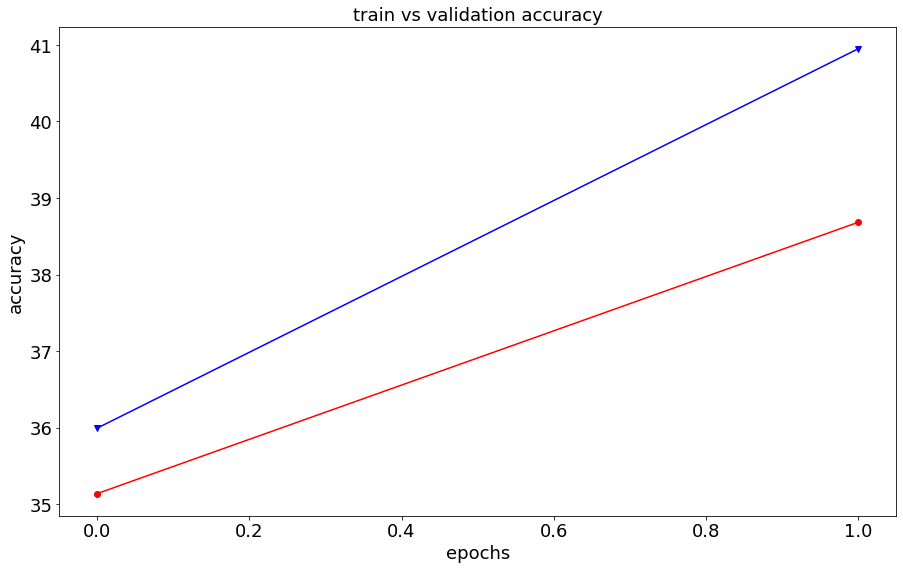

In [21]:
plot_scores("accuracy", train_accs, val_accs, NUM_EPOCHS, selected_epoch)

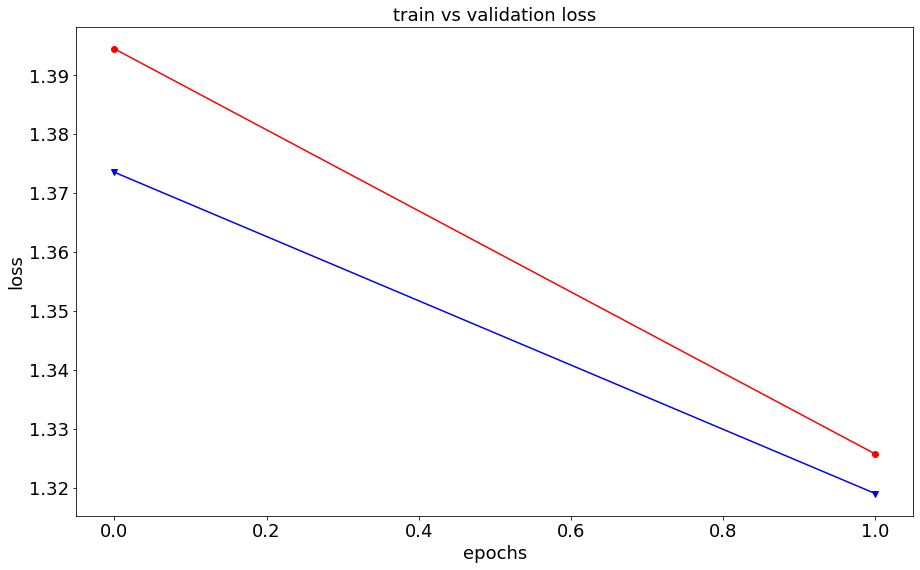

In [22]:
plot_scores("loss", train_losses, val_losses, NUM_EPOCHS, selected_epoch)

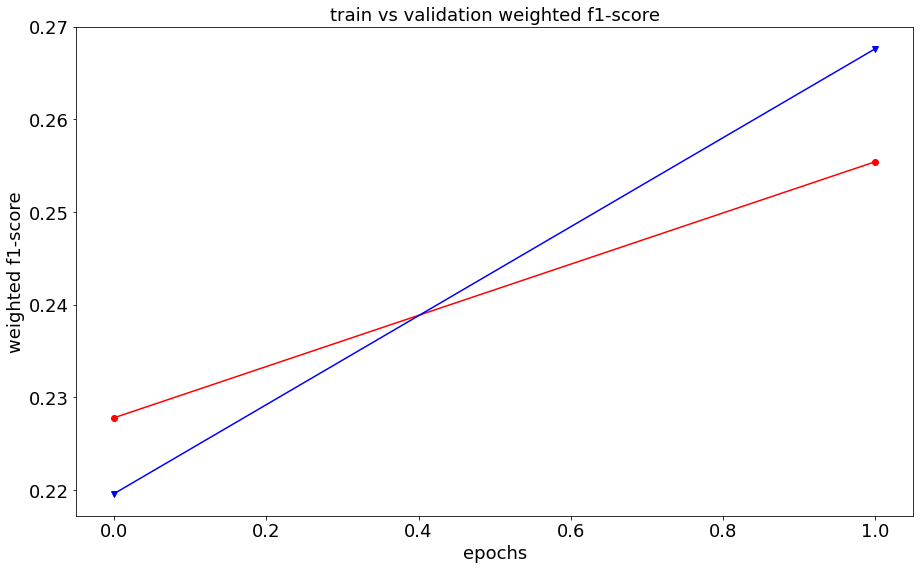

In [23]:
plot_scores('weighted f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [24]:
eval(model=model, test_loader=test_loader)

Test Accuracy:  34.596, Test Loss:  1.376, Test Weighted F1:  0.205


# **Transfer Learning**

In [25]:
from torchvision import models

###ResNet-18

In [26]:
# resize to same shape and convert to tensor
tm_transform = transforms.Compose([transforms.ToPILImage(), 
                                   transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda img: img.repeat(3, 1, 1) ), # repeat single channel thrice to get 3-channel 
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

# load datasets
train_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_train.csv', 
                                        img_dir='/tmp/5_class/train_images', transform=tm_transform)
val_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_val.csv', 
                                        img_dir='/tmp/5_class/validation_images', transform=tm_transform)
test_dataset = BanglaLekhaAesScoreLabledDataset(labels_csv_file='/tmp/5_class/scoreLabel_test.csv', 
                                        img_dir='/tmp/5_class/test_images', transform=tm_transform)

# data-loaders

batch_size = 100 # no of samples in a single batch

set_global_seed()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
set_global_seed()
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


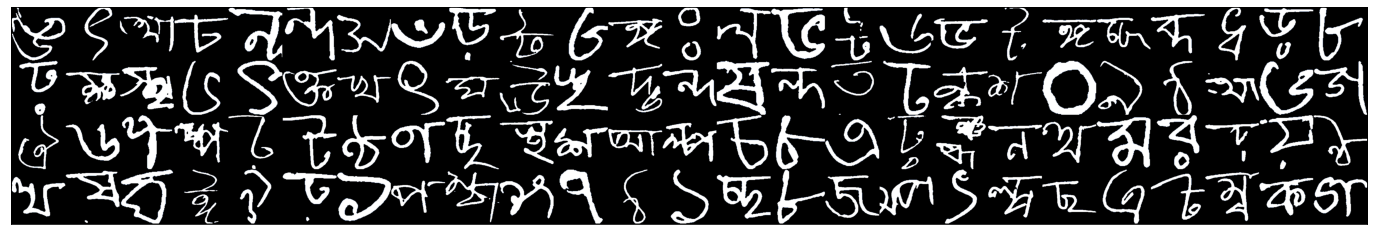

In [27]:
show_batch(val_loader)

In [28]:
class ResNetTM(nn.Module):
  def __init__(self):
    super(ResNetTM, self).__init__()

    # # convert 1 channel to 3 channels
    # self.conv = nn.Sequential(
    #     nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
    #     nn.BatchNorm2d(3),
    #     nn.Dropout(0.25),
    #     nn.ReLU()
    # )
    
    # ResNet-18
    self.base_model = models.resnet18(pretrained=True)
    # freeze resnet beginning layers
    for param in self.base_model.parameters():
      param.requires_grad = False

    # output to one neuron
    self.base_model.fc = nn.Sequential(
        nn.Linear(self.base_model.fc.in_features, 5),
        nn.ReLU()
    )

  def forward(self, input):
    output = self.base_model(input)
    return output

In [29]:
# init model with ResNet-18
set_global_seed()

model = ResNetTM()
model = model.to(device)

# init loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model,selected_epoch, train_accs,train_losses,train_f1s, val_accs,val_losses,val_f1s = train(model, optimizer, criterion, train_loader, val_loader, NUM_EPOCHS)

Epoch 0/1
---------------
train Loss: 1.4119 Acc: 38.2718, Weighted F1: 0.2388
val Loss: 1.4307 Acc: 35.1801, Weighted F1: 0.2203
Minimum train-val accuracy difference reduced 	 Saving Model!

Epoch 1/1
---------------
train Loss: 1.3822 Acc: 40.0694, Weighted F1: 0.2526
val Loss: 1.4148 Acc: 37.6054, Weighted F1: 0.2125
Minimum train-val accuracy difference reduced 	 Saving Model!

Training complete in 18m 28s
Train Acc: 40.069353, Weighted F1-score: 0.252594
Validation Acc: 37.605364 Weighted F1-score: 0.212511


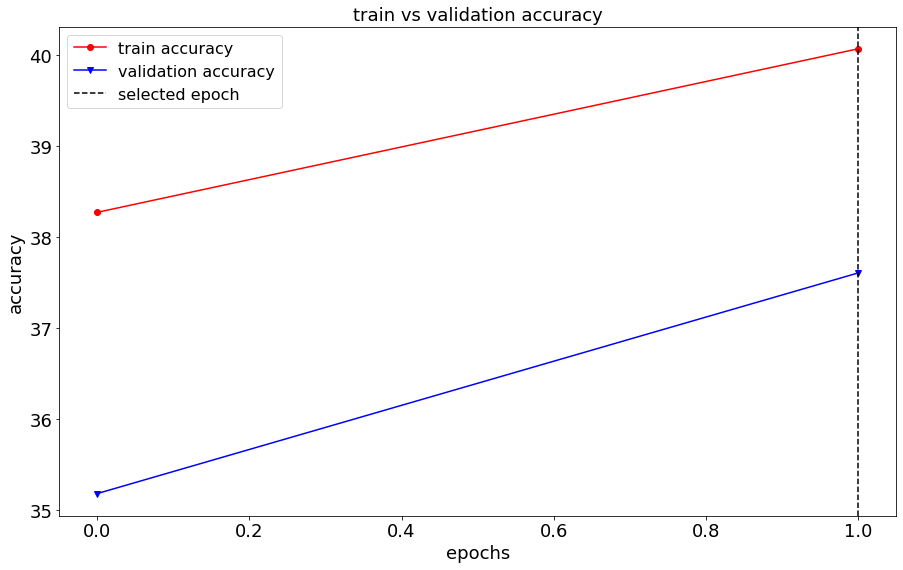

In [30]:
plot_scores('accuracy', train_accs, val_accs, NUM_EPOCHS, selected_epoch)

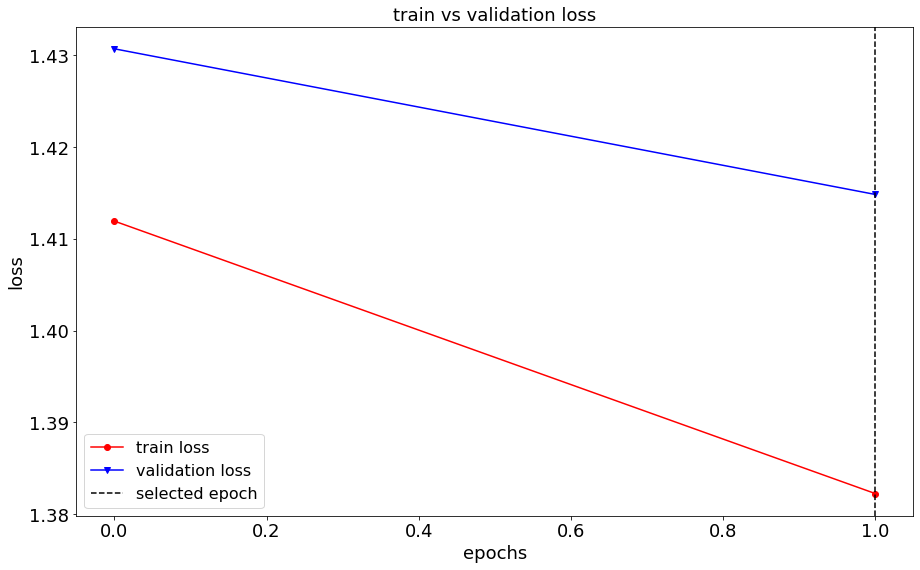

In [31]:
plot_scores('loss', train_losses, val_losses, NUM_EPOCHS, selected_epoch)

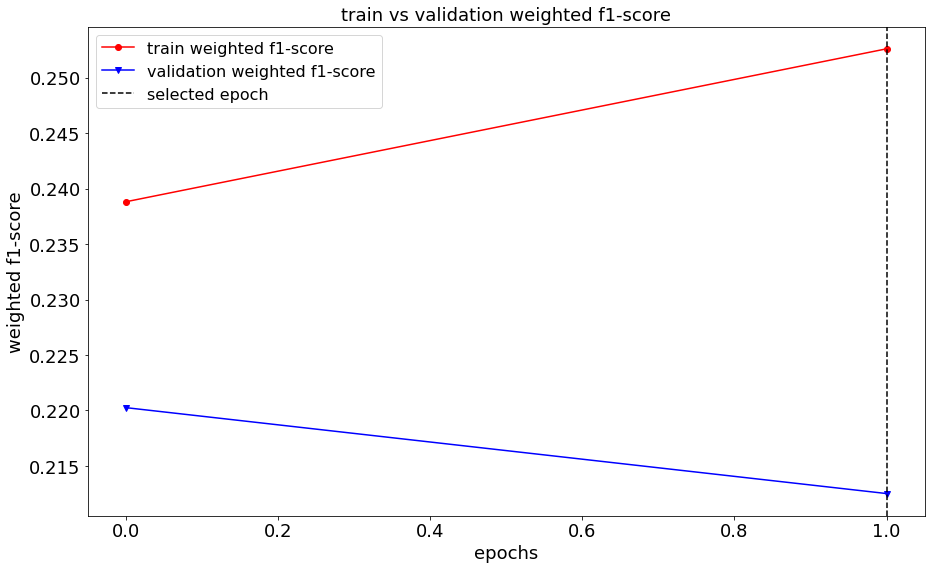

In [32]:
plot_scores('weighted f1-score', train_f1s, val_f1s, NUM_EPOCHS, selected_epoch)

In [33]:
eval(model=model, test_loader=test_loader)

Test Accuracy:  37.958, Test Loss:  1.411, Test Weighted F1:  0.208
